In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate,GlobalMaxPool2D,Multiply
from tensorflow.keras.layers import Dropout, Subtract, Add, GlobalAvgPool2D, Conv2D, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda,concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import glorot_uniform, Constant
from sklearn.model_selection import train_test_split
import os
import json

In [2]:
print("Loading training file from path: ", config.config_io.get('pan_20_processed_train_wide')) # pan_20_processed_train_wide
training_data = pd.read_csv(config.config_io.get('pan_20_processed_train_wide'))
training_data.head()

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan20-style-change-detection/processed/train/wide.csv


,problem,author_1,author_2,para1_text,para2_text
0,problem-4845.txt,A1,A1,My understanding is that meditation went throu...,what's the distinction between Dharmaguptaka a...
1,problem-4845.txt,A1,A1,what's the distinction between Dharmaguptaka a...,What's the history behind this? I am assuming ...
2,problem-4845.txt,A1,A1,What's the history behind this? I am assuming ...,"During an course I attended under the name ""In..."
3,problem-4845.txt,A1,A1,"During an course I attended under the name ""In...","in the city where i live (Toronto, although th..."
4,problem-4845.txt,A1,A1,"in the city where i live (Toronto, although th...","As a Western Buddhist, I'd say the advice is i..."


In [3]:
training_data.shape

(136776, 5)

In [50]:
sum(training_data['author_1']== training_data['author_2'])/len(training_data)

0.5

In [24]:
#getting a balanced dataset
same_author = training_data[training_data['author_1']== training_data['author_2']]
diff_author = training_data[training_data['author_1']!= training_data['author_2']]

In [27]:
diff_author.shape

(23004, 5)

In [28]:
same_author.shape

(113772, 5)

In [29]:
new_training_data = pd.concat([diff_author, same_author[0:len(diff_author)]])

In [32]:
new_training_data.shape

(46008, 5)

In [33]:
new_training_data = new_training_data.sample(frac=1).reset_index(drop=True)

In [34]:
new_training_data.to_csv("new_training.csv", index=False)

In [35]:
training_data = new_training_data

In [ ]:
training_data = pd.read_csv(config.config_io.get('new_training.csv'))

In [36]:
combined = training_data["para1_text"] + " " + training_data["para2_text"]

In [37]:
max_words = 10000
t = Tokenizer(num_words=max_words, oov_token="<OOV>")
t.fit_on_texts(combined.values)


In [38]:
max_len = 300

We see that most of the values are less than say len 100, so we can infact try with length 200 and see how that goes

In [39]:
embeddings_index = {}
f = open('/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [40]:
def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer
    
    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix

In [41]:
embedding_dim = 50
embed_matrix = get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = embedding_dim)

Loaded 400000 word vectors.


In [42]:
embed_matrix.shape

(106945, 50)

In [43]:
from src.DataGeneratorSiamese import DataGeneratorSiamese
len_train = len(training_data)
#
#
training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=t,max_len=max_len, batch_size=64)
validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=t, max_len=max_len, batch_size=64)

# this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
training_generator.on_epoch_end()
validation_generator.on_epoch_end()

In [44]:
def manh_lstm_distance(left, right):
    distance = tf.keras.backend.abs(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance

In [45]:
def exponent_neg_cosine_distance(left,right):
    left = tf.keras.backend.l2_normalize(left, axis=-1)
    right = tf.keras.backend.l2_normalize(right, axis=-1)
    return tf.keras.backend.exp(tf.keras.backend.sum(tf.keras.backend.prod([left, right], axis=0), axis=1, keepdims=True))

In [46]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return tf.keras.backend.exp.exp(-tf.keras.backend.exp.sum(tf.keras.backend.exp.abs(left-right), axis=1, keepdims=True))

In [47]:
def exponent_neg_euclidean_distance(left, right):
    distance = tf.keras.backend.square(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = tf.keras.backend.sqrt(distance, axis = 1, keepdims = True)
    distance = tf.keras.backend.exp(-distance)
    return distance

In [48]:
input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
input_2 = Input(shape=(max_len,))


lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#lstm_layer = tf.keras.layers.LSTM(50, name="common_lstm_layer")
# max_words 10000 , embedding_dim = 50, max_len = 300
embeddings_initializer = Constant(embed_matrix)
emb =  Embedding(len(t.word_index)+1, 
                 embedding_dim, 
                 embeddings_initializer=embeddings_initializer,
                 input_length=max_len, 
                 weights=[embed_matrix],
                 trainable=True)

e1 = emb(input_1)
x1 = lstm_layer(e1)

e2 = emb(input_2)
x2 = lstm_layer(e2)

#concats = concatenate([x1, x2], axis=-1)
#merged = Lambda(exponent_neg_cosine_distance, output_shape=(1,))(concats)

mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) #manh_lstm_distance
merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
preds = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_1, input_2], outputs=preds)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))


In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 50)      5347250     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100)          40400       embedding_1[0][0]          

In [51]:
history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=64, 
                             epochs=50, steps_per_epoch=100) #, callbacks=[callback]

Epoch 1/50
100/100 [==============================] - 42s 378ms/step - loss: 0.8559 - acc: 0.4957 - val_loss: 0.7619 - val_acc: 0.5009
Epoch 2/50
100/100 [==============================] - 39s 392ms/step - loss: 0.7460 - acc: 0.5079 - val_loss: 0.7366 - val_acc: 0.5009
Epoch 3/50
100/100 [==============================] - 39s 392ms/step - loss: 0.7279 - acc: 0.4963 - val_loss: 0.7146 - val_acc: 0.5009
Epoch 4/50
100/100 [==============================] - 39s 387ms/step - loss: 0.7145 - acc: 0.4828 - val_loss: 0.7715 - val_acc: 0.5009
Epoch 5/50
100/100 [==============================] - 39s 385ms/step - loss: 0.7120 - acc: 0.5047 - val_loss: 0.6901 - val_acc: 0.5316
Epoch 6/50
100/100 [==============================] - 38s 384ms/step - loss: 0.6869 - acc: 0.5267 - val_loss: 0.6837 - val_acc: 0.5633
Epoch 7/50
100/100 [==============================] - 39s 386ms/step - loss: 0.6776 - acc: 0.5629 - val_loss: 0.6818 - val_acc: 0.5758
Epoch 8/50
100/100 [==============================] - 3

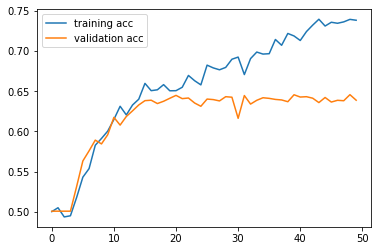

In [52]:
acc = pd.DataFrame({"training acc":history.history['acc'], 
                            "validation acc": history.history['val_acc']})
acc.plot()

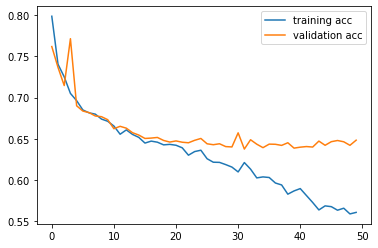

In [53]:
loss = pd.DataFrame({"training acc":history.history['loss'], 
                            "validation acc": history.history['val_loss']})
loss.plot()

In [54]:
testing_data = pd.read_csv(config.config_io.get('pan_20_processed_test_wide'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=t, max_len=max_len, batch_size=64)
testing_generator.on_epoch_end()

In [55]:
test_loss, test_acc = model.evaluate(testing_generator)

1061/1061 [==============================] - 47s 44ms/step - loss: 0.6192 - acc: 0.6330


In [56]:
testing_data = pd.read_csv(config.config_io.get('pan_20_processed_test_narrow'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=t, max_len=max_len, batch_size=64)
testing_generator.on_epoch_end()

In [57]:
test_loss, test_acc = model.evaluate(testing_generator)

652/652 [==============================] - 29s 45ms/step - loss: 0.5524 - acc: 0.7051
